# Building Footprints as Vectors

This notebook demonstrates converting the building footprint raster that
is the output of the Analaytics feed into a vector dataset.

It demonstrates the following techniques for converting to vector:
1. GDAL CLI
2. Rasterio (no processing)
3. Rasterio (with simplification)
4. Rasterio (arbitrary function, filtering and simplification as example)

In [1]:
import os
from pprint import pprint

import fiona
import matplotlib.pyplot as plt
from planet import api
from planet.api.utils import write_to_file
import rasterio
from rasterio import features as rfeatures
from rasterio.enums import Resampling
from rasterio.plot import show
import shapely
from shapely.geometry import shape as sshape

In [2]:
# if your Planet API Key is not set as an environment variable, you can paste it below
API_KEY = os.environ.get('PL_API_KEY', 'PASTE_YOUR_KEY_HERE')

analytics_client = api.ClientV1(api_key=API_KEY)

## Obtain Analytics Raster

### Identify road feed feature for download

We want to download the most recent feature from the feed for road detection in Kirazli, Turkey.

In [3]:
# # uncomment to get feed ids
# feeds = analytics_client.list_analytic_feeds({}).get()
# for d in feeds['data']:
#     print('{} ({}):\n\r{}\n\r'.format(d['id'], d['created'], d['description']))

In [4]:
# # uncomment to get subscription ids
# FEED_ID = 'b442c53b-fc72-4bee-bab4-0b7aa318ccd9'
# subscriptions = analytics_client.list_analytic_subscriptions(FEED_ID).get()
# for d in subscriptions['data']:
#     print('{} ({}):\n\r{}\n\r'.format(d['id'], d['created'], d['title']))

In [5]:
# building footprints in Sazgin, Turkey
SUBSCRIPTION_ID = '02c4f912-090f-45aa-a18b-ac4a55e4b9ba'

In [7]:
# Get subscription details
# subscription_info = analytics_client.get_subscription_info(SUBSCRIPTION_ID).get()
# pprint(subscription_info)

In [8]:
results = analytics_client.list_collection_features(SUBSCRIPTION_ID).get()
features = results['features']
print('{} features in collection'.format(len(features)))

36 features in collection


In [9]:
# sort features by acquisition date and take latest feature
features.sort(key=lambda k: k['properties']['first_acquired'])
feature = features[-1]
print(feature['properties']['first_acquired'])

2019-11-01T00:00:00Z


### Download Quad Raster

In [10]:
RESOURCE_TYPE = 'target-quad'

In [11]:
def create_save_dir(root_dir='data'):
    save_dir = root_dir

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    return save_dir

dest = 'data/footprints'
create_save_dir(dest)

'data/footprints'

In [13]:
def download_feature(feature, subscription_id, resource_type, dest=dest):
    # making a long name shorter
    get_resource = analytics_client.get_associated_resource_for_analytic_feature

    resource = get_resource(subscription_id, feature['id'], resource_type)
    filename = download_resource(resource, dest)
    return filename

def download_resource(resource, dest, overwrite=False):
    writer = write_to_file(dest, overwrite=overwrite)
    writer(resource)
    filename = os.path.join(dest, resource.name)
    print('file saved to: {}'.format(filename))
    return filename

filename = download_feature(feature, SUBSCRIPTION_ID, RESOURCE_TYPE)

file saved to: data/footprints/L15-1237E-1251N.tif


### Visualize Roads Image

The output of the analytics road detection is a boolean image where road pixels are given a value of True and non-road pixels are given a value of False.

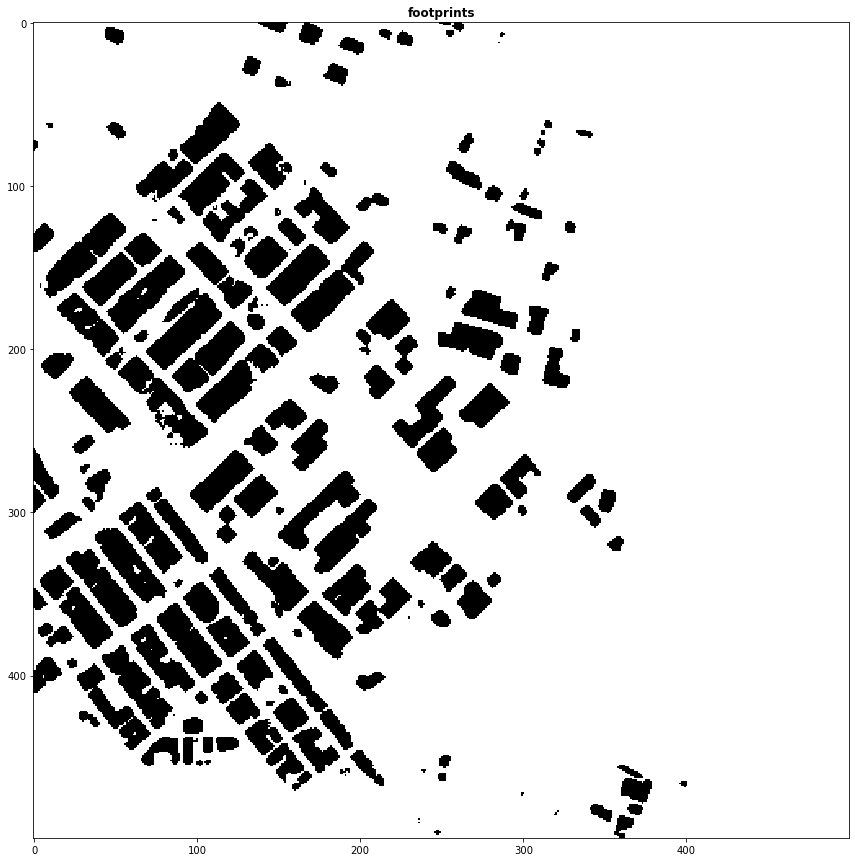

In [14]:
def _open(filename, factor=1):
    with rasterio.open(filename) as dataset:
        height = int(dataset.height / factor)
        width = int(dataset.width / factor)
        data = dataset.read(
            out_shape=(dataset.count, height, width)
        )
    return data

def open_bool(filename, factor=1):
    data = _open(filename, factor=factor)
    return data[0,:,:]

def get_figsize(factor):
    return tuple(2 * [int(25/factor)])



factor = 1
figsize = (15, 15)

roads = open_bool(filename, factor=factor)
fig = plt.figure(figsize=figsize)
# show(roads, title="footprints", cmap="binary")
show(roads[2500:3000, 0:500], title="footprints", cmap="binary")

## Convert Buildings to Vector Features

### GDAL Command-Line Interface (CLI)

GDAL provides a python script that can be run via the CLI. It is quite easy to run and fast.

In [15]:
def get_layer_name(filename):
    # get the default layer output layer name based on the 
    # output filename. I wish there was a way to specify
    # the output layer name but attempts have failed thus far.
    return filename.split('/')[-1].split('.')[0]

gdal_tmp_output_filename = os.path.join(dest, 'test_gdal_all.shp')
gdal_tmp_output_layer_name = get_layer_name(gdal_tmp_output_filename)
gdal_output_filename = os.path.join(dest, 'test_gdal.shp')
gdal_output_layer_name = get_layer_name(gdal_output_filename)

In [16]:
# convert the binary image into polygons
# creates polygons for building footprints as well as regions between
# and around building footprints
!gdal_polygonize.py $filename $gdal_tmp_output_filename

0...10...20...30...40...50...60...70...80...90...100 - done.


In [17]:
# get number of features, this includes inside and outside building footprints
!ogrinfo -so  $gdal_tmp_output_filename $gdal_tmp_output_layer_name | grep 'Feature Count'

Feature Count: 4092


In [18]:
# get number of building footprint features
# building footprints are associated with image value (DN) of 255
!ogrinfo -so $gdal_tmp_output_filename -sql "SELECT * FROM $gdal_tmp_output_layer_name WHERE DN=255" \
    | grep 'Feature Count'

Feature Count: 3772


In [19]:
# create a new shapefile with only building footprints
!ogr2ogr -sql "SELECT * FROM $gdal_tmp_output_layer_name WHERE DN=255" \
    $gdal_output_filename $gdal_tmp_output_filename

In [20]:
# confirm the number of building footprint features
!ogrinfo -so $gdal_output_filename -sql "SELECT * FROM $gdal_output_layer_name WHERE DN=255" \
    | grep 'Feature Count'

Feature Count: 3772


### Rasterio

In this section we use rasterio to convert the binary buildings raster into a vector dataset. The vectors are written to disk as a shapefile. The shapefile can be imported into geospatial programs such as QGIS or ArcGIS for visualization and further processing.

This is basic conversion to vector shapes. No smoothing to remove pixel edges, or conversion to the road centerlines is performed here.

In [21]:
def buildings_as_vectors(filename): 
    with rasterio.open(filename) as dataset:
        buildings = dataset.read(1)
        building_mask = buildings == 255 # mask non-building pixels

        # transforms roads features to image crs
        building_shapes = rfeatures.shapes(buildings, mask=building_mask, transform=dataset.transform)
        building_geometries = (s for s, _ in building_shapes)
        
        crs = dataset.crs
    return (building_geometries, crs)

def save_as_shapefile(output_filename, geometries, crs):
    driver='ESRI Shapefile'
    schema = {'geometry': 'Polygon', 'properties': []}
    with fiona.open(output_filename, mode='w', driver=driver, schema=schema, crs=crs) as c:
        count = 0
        for g in geometries:
            count += 1;
            c.write({'geometry': g, 'properties': {}})
        print('wrote {} geometries to {}'.format(count, output_filename))

        
building_geometries, crs = buildings_as_vectors(filename)
output_filename = os.path.join(dest, 'test_rasterio.shp')
save_as_shapefile(output_filename, building_geometries, crs)

wrote 3772 geometries to data/footprints/test_rasterio.shp


### Rasterio - Simplifying

In this section, we use `shapely` to simplify the building footprints so we don't have a million pixel edges.

In [22]:
def buildings_as_vectors_with_simplification(filename): 
    with rasterio.open(filename) as dataset:
        buildings = dataset.read(1)
        building_mask = roads == 255 # mask non-building pixels

        # we skip transform on vectorization so we can perform filtering in pixel space
        building_shapes = rfeatures.shapes(buildings, mask=building_mask)
        building_geometries = (s for s, _ in building_shapes)
        geo_shapes = (sshape(g) for g in building_geometries)
    
        # simplify so we don't have a million pixel edge points
        # value of 1 (in units of pixels) determined by visual comparison to non-simplified
        tolerance = 1
        geo_shapes = (g.simplify(tolerance, preserve_topology=False)
                      for g in geo_shapes)

        # apply image transform    
        # rasterio transform: (a, b, c, d, e, f, 0, 0, 1), c and f are offsets
        # shapely: a b d e c/xoff f/yoff
        d = dataset.transform
        shapely_transform = [d[0], d[1], d[3], d[4], d[2], d[5]]
        proj_shapes = (shapely.affinity.affine_transform(g, shapely_transform)
                       for g in geo_shapes)
        
        building_geometries = (shapely.geometry.mapping(s) for s in proj_shapes)
        
        crs = dataset.crs
    return (building_geometries, crs)

building_geometries_simp, crs = buildings_as_vectors_with_simplification(filename)
output_filename = os.path.join(dest, 'test_rasterio_simp.shp')
save_as_shapefile(output_filename, building_geometries_simp, crs)

wrote 3772 geometries to data/footprints/test_rasterio_simp.shp


### Rasterio - Arbitrary Calculation

In this section we get a little bit fancy and set up the rasterio vectorization function so that it can take any calculation function, as long as that function has a generator of `rasterio.shape` as input and a generator of `rasterio.shape` as output. We will use this to filter and simplify building footprint shapes.

In [23]:
def buildings_as_vectors_proc(filename, proc_fcn): 
    with rasterio.open(filename) as dataset:
        buildings = dataset.read(1)
        building_mask = roads == 255 # mask non-building pixels

        # we skip transform on vectorization so we can perform filtering in pixel space
        building_shapes = rfeatures.shapes(buildings, mask=building_mask)
        building_geometries = (s for s, _ in building_shapes)
        geo_shapes = (sshape(g) for g in building_geometries)
        
        # apply arbitrary processing function
        geo_shapes = proc_fcn(geo_shapes)

        # apply image transform    
        # rasterio transform: (a, b, c, d, e, f, 0, 0, 1), c and f are offsets
        # shapely: a b d e c/xoff f/yoff
        d = dataset.transform
        shapely_transform = [d[0], d[1], d[3], d[4], d[2], d[5]]
        proj_shapes = (shapely.affinity.affine_transform(g, shapely_transform)
                       for g in geo_shapes)
        
        building_geometries = (shapely.geometry.mapping(s) for s in proj_shapes)
        
        crs = dataset.crs
    return (building_geometries, crs)

def filter_and_simplify_footprints(footprints):
    # filter to shapes consisting of 6 or more pixels
    min_pixel_size = 6
    geo_shapes = (s for s in footprints if s.area >= min_pixel_size)
        
    # simplify so we don't have a million pixel edge points
    # value of 1 (in units of pixels) determined by visual comparison to non-simplified
    tolerance = 1
    geo_shapes = (s.simplify(tolerance, preserve_topology=False)
                  for s in geo_shapes)
    return geo_shapes

building_geometries_simp, crs = buildings_as_vectors_proc(filename, filter_and_simplify_footprints)
output_filename = os.path.join(dest, 'test_rasterio_proc.shp')
save_as_shapefile(output_filename, building_geometries_simp, crs)

wrote 3437 geometries to data/footprints/test_rasterio_proc.shp
